# Exploration of Sentinel-1 Level-2 Ocean Wind Field (OWI) component

In [1]:
import zipfile as zf
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Load S1 OCN NetCDF dataset located in test sub folder

In [2]:
import os
import re
import glob
from datetime import datetime

data_path = os.path.join( os.getcwd(), 'data' )
files = glob.glob( os.path.join( data_path, '*.zip' ) )
files

['C:\\Users\\crwil\\Documents\\GitHub\\s1-ocn\\notebooks\\data\\S1A_IW_OCN__2SDV_20200724T180617_20200724T180642_033600_03E4E0_840D.zip']

In [3]:
def loadDataset( pathname ):

    # extract the file in the current directory.
    with zf.ZipFile(pathname, 'r') as zip:
        zip.extractall( data_path )
                
    path = os.path.splitext( pathname )[ 0 ] + '.SAFE'
    path = os.path.join( os.path.join( path, '**' ), '*.nc' )
    nc_file = glob.glob( path, recursive=True )[ 0 ]

    return nc.Dataset( nc_file )

In [4]:
def getDateTime( pathname ):

    """
    parse date time sub-folder name from pathname
    """

    dt = None

    # parse for date time sub directory
    m = re.search( '[0-9]{8}t[0-9]{6}', pathname )
    if m:
        dt = datetime.strptime( str(m.group(0) ), '%Y%m%dt%H%M%S')

    return dt

In [5]:
nc_dataset = loadDataset ( files[ 0 ] )
print ( nc_dataset.filepath() )
date_time = getDateTime( os.path.basename( nc_dataset.filepath() ) )

C:\Users\crwil\Documents\GitHub\s1-ocn\notebooks\data\S1A_IW_OCN__2SDV_20200724T180617_20200724T180642_033600_03E4E0_840D.SAFE\measurement\s1a-iw-ocn-vv-20200724t180617-20200724t180642-033600-03E4E0-001.nc


### Visualisation of swath-based S1-OCN wind speed and direction 

(<AxesSubplot:title={'center':'OWI Wind Direction'}>,
 Text(0.5, 1.0, 'OWI Wind Direction'))

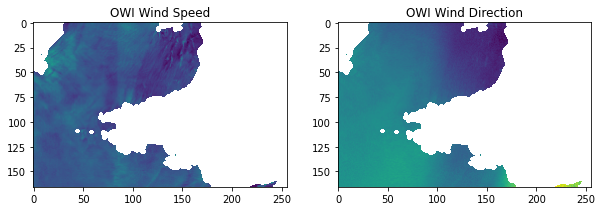

In [6]:
owiSpeed = np.array( nc_dataset.variables['owiWindSpeed'])
owiSpeed[owiSpeed == -999.0] = np.nan

owiDir = np.array( nc_dataset.variables['owiWindDirection'])
owiDir[owiDir == -999.0] = np.nan

fig = plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(np.flipud(owiSpeed), cmap='viridis'), plt.title('OWI Wind Speed')
plt.subplot(122), plt.imshow(np.flipud(owiDir), cmap='viridis'), plt.title('OWI Wind Direction')

In [7]:
def getWindFieldPlot( speed, direction, x_coords, y_coords, extent=None, transform=ccrs.PlateCarree(), title='' ):

    # create figure
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # draw wind speed colormap
    carto_map = ax.contourf(  x_coords, y_coords, speed, 100, 
                        transform=transform,
                        cmap='jet',
                        vmax=10.0 )

    ax.set_title(title,
                 fontsize=16,
                 fontweight='bold',
                 loc='left')

    # set extent if defined
    if extent is not None:        
        x_min, y_min, x_max, y_max = extent
        ax.set_xlim( x_min, x_max )
        ax.set_ylim( y_min, y_max )

    # mask land regions and coastlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                edgecolor='face', 
                                                facecolor='w') )
    ax.coastlines(resolution='10m', linewidth=2, color='black')
    
    # plot colorbar
    cbar = plt.colorbar(carto_map, shrink=0.42)
    cbar.set_label('SAR Wind Speed [m.s-1]',
               fontsize=15, 
               labelpad=25)

    # draw wind vectors
    dx = np.cos(direction * np.pi / 180)  # u
    dy = np.sin(direction * np.pi / 180)  # v
    
    ax.quiver( x_coords, y_coords, dx, dy, 
              transform=transform,
              angles="xy", 
              color="black", 
              regrid_shape=20)

    # draw gridlines and lat lon ticks on the axis
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True,
                      linewidth=2, 
                      color='gray', 
                      alpha=0.8, 
                      linestyle=':')    
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # setup labels
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'color': 'black', 'weight': 'bold', 'size': 10}
    gl.ylabel_style = {'color': 'black', 'weight': 'bold', 'size': 10}
    
    return

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


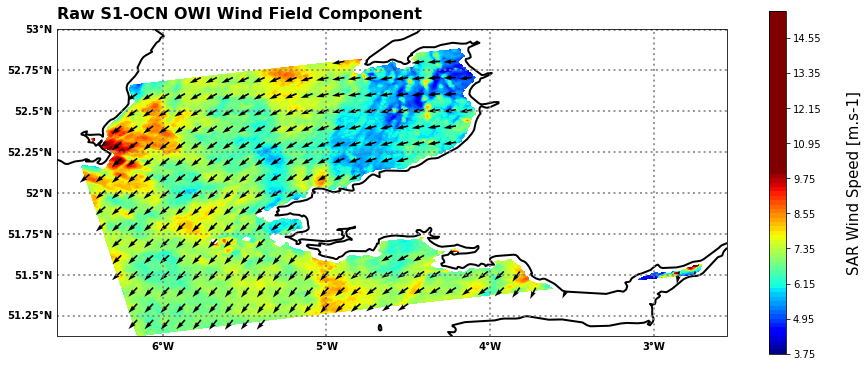

In [8]:
lat = np.array(nc_dataset.variables['owiLat'])
lon = np.array(nc_dataset.variables['owiLon'])

geo_extent = ( np.amin(lon), np.amin(lat), np.amax(lon), np.amax(lat) )
getWindFieldPlot( owiSpeed, owiDir, lon, lat, extent=geo_extent, title='Raw S1-OCN OWI Wind Field Component')

### Transformation between wind speed / direction and u,v component vectors

To resample OWI wind field products onto a common grid for time series analysis, need to convert wind speed / direction to u,v component vectors to overcome discontinuity in wind direction at 360°/0°.

In [9]:
def wind_spddir_to_uv(wspd,wdir):
    """
    calculated the u and v wind components from wind speed and direction
    Input:
        wspd: wind speed
        wdir: wind direction
    Output:
        u: u wind component
        v: v wind component
    """    
    
    rad = 4.0*np.arctan(1)/180.
    u = -wspd*np.sin(rad*wdir)
    v = -wspd*np.cos(rad*wdir)

    return u,v

In [10]:
def wind_uv_to_dir(U,V):
    """
    Calculates the wind direction from the u and v component of wind.
    Takes into account the wind direction coordinates is different than the 
    trig unit circle coordinate. If the wind directin is 360 then returns zero
    (by %360)
    Inputs:
      U = west/east direction (wind from the west is positive, from the east is negative)
      V = south/noth direction (wind from the south is positive, from the north is negative)
    """
    WDIR= (270-np.rad2deg(np.arctan2(V,U)))%360
    return WDIR

In [11]:
def wind_uv_to_spd(U,V):
    """
    Calculates the wind speed from the u and v wind components
    Inputs:
      U = west/east direction (wind from the west is positive, from the east is negative)
      V = south/noth direction (wind from the south is positive, from the north is negative)
    """
    WSPD = np.sqrt(np.square(U)+np.square(V))
    return WSPD

###  S1-OCN OWI Wind Field component vector dataset resampled onto EPSG:27700 grid

In [12]:
from osgeo import gdal

# turn on warning / error reporting
gdal.UseExceptions()

def getComponentVectorFile( nc_dataset, out_path ):
    
    # create output path
    if not os.path.exists( out_path ):
        os.makedirs( out_path )

    # create geotiff for u,v components
    out_pathname = os.path.join( out_path, 'owi.tif' )
    ds = gdal.GetDriverByName('GTIFF').Create( out_pathname,
                                        owiSpeed.shape[1], 
                                        owiSpeed.shape[0], 
                                        2, 
                                        gdal.GDT_Float32 )

    # write data to newly created file
    ds.GetRasterBand(1).WriteArray( np.flipud( u.reshape( owiSpeed.shape ) ) )
    ds.GetRasterBand(2).WriteArray( np.flipud( v.reshape( owiSpeed.shape ) ) )
    ds.FlushCache()
    ds = None
    
    return out_pathname

In [13]:
def getGeolocWarpVrtFile( nc_dataset, owi_file ):

    # open source file
    src_ds = gdal.Open( owi_file, gdal.GA_ReadOnly )

    # transform source file to vrt 
    out_pathname = owi_file.replace( '.tif', '.vrt' )
    ds = gdal.Translate( out_pathname, src_ds, format='VRT' )

    # add geoloc meta fields to vrt file
    meta = {
        'X_DATASET': 'NETCDF:"' + nc_dataset.filepath() + '":owiLon',
        'X_BAND': '1',
        'Y_DATASET': 'NETCDF:"' + nc_dataset.filepath() + '":owiLat',
        'Y_BAND': '1',
        'PIXEL_OFFSET': '0',
        'LINE_OFFSET': '0',
        'PIXEL_STEP': '1',
        'LINE_STEP': '1' 
    }
    
    # set metadata and flush
    ds.SetMetadata( meta, "GEOLOCATION")
    ds.FlushCache( )
    ds = None
    
    return out_pathname

In [14]:
def getWarpFile( in_pathname, out_pathname, **kwargs ):

    # open source file and execute warp
    src_ds = gdal.Open( in_pathname )
    ds = gdal.Warp( out_pathname, 
                        src_ds, 
                        **kwargs )
    
    # flush cache 
    ds.FlushCache()
    ds = None
    
    return

In [15]:
# convert wind speed / direction to u,v component vector
u,v = wind_spddir_to_uv( owiSpeed.flatten(), owiDir.flatten() )
#u.reshape( owiSpeed.shape ).shape, v.reshape( owiSpeed.shape ).shape

In [16]:
# get geolocation warp vrt file
out_path = os.path.join( os.path.dirname( nc_dataset.filepath() ), 'tmp' )
vrt_pathname = getGeolocWarpVrtFile( nc_dataset, 
                                    getComponentVectorFile( nc_dataset, out_path ) )

In [17]:
# aoi / resolution defining common grid
resolution = 500
bounds = ( 40000.,  -20000., 340000., 300000. )

In [18]:
# create output path
root_path = 'C:\\Users\\crwil\\Documents\\data\\warp'
if not os.path.exists( root_path ):
    os.makedirs( root_path )

# generate warp file

out_pathname = os.path.join( root_path, os.path.splitext( os.path.basename( nc_dataset.filepath() ) )[0] + '-grid.tif' )

kwargs = {  'format': 'GTiff', 
            'geoloc': True, 
            'resampleAlg' : gdal.GRIORA_Cubic, 
            'outputBounds' : bounds,
            'outputBoundsSRS' : 'EPSG:27700', 
            'srcSRS' : 'EPSG:4326',           
            'dstSRS' : 'EPSG:27700', 
            'xRes' : resolution, 
            'yRes' : resolution,
            'dstNodata' : np.nan
}
getWarpFile( vrt_pathname, out_pathname, **kwargs )

### Visualisation of resampled OWI Wind Field Dataset (500m grid spacing) 

In [19]:
# open source file and execute wa
ds = gdal.Open( out_pathname )
u = ds.GetRasterBand(1).ReadAsArray()
v = ds.GetRasterBand(2).ReadAsArray()

ws = wind_uv_to_spd ( u.flatten(), v.flatten() )
wd = wind_uv_to_dir ( u.flatten(), v.flatten() )

ws = ws.reshape( u.shape )
wd = wd.reshape( u.shape )

(<AxesSubplot:title={'center':'OWI Wind Direction'}>,
 Text(0.5, 1.0, 'OWI Wind Direction'))

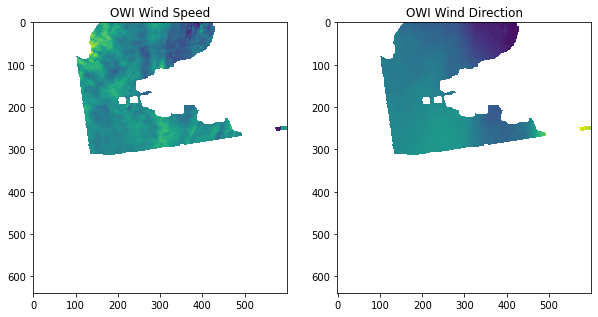

In [20]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(ws, cmap='viridis'), plt.title('OWI Wind Speed')
plt.subplot(122), plt.imshow(wd, cmap='viridis'), plt.title('OWI Wind Direction')

In [21]:
# compute x, y map coordinates from geo transform
from affine import Affine
affine = Affine.from_gdal(*ds.GetGeoTransform())

x_coords, _ = affine * (np.arange( ds.RasterXSize ) + 0.5, np.zeros( ds.RasterXSize ) + 0.5)
_, y_coords = affine * (np.zeros( ds.RasterYSize) + 0.5, np.arange( ds.RasterYSize ) + 0.5)

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


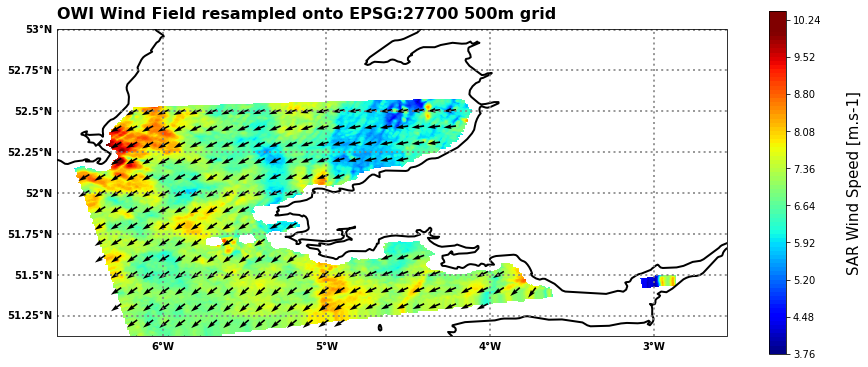

In [22]:
# plot regridded wind field
getWindFieldPlot( ws, 
                  wd, 
                 x_coords, 
                 y_coords, 
                 extent=geo_extent, 
                 transform=ccrs.epsg(27700), 
                 title='OWI Wind Field resampled onto EPSG:27700 500m grid' )